In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from wordcloud import WordCloud

In [2]:
hillary_df = pd.read_csv('data/hillary_location.csv')
trump_df = pd.read_csv('data/trump_location.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
all_df = hillary_df.append(trump_df)

In [4]:
len(all_df)

1240276

In [5]:
all_df.drop_duplicates(subset='id', inplace=True)
len(all_df)

1222413

In [6]:
all_df.text.fillna('', inplace=True)

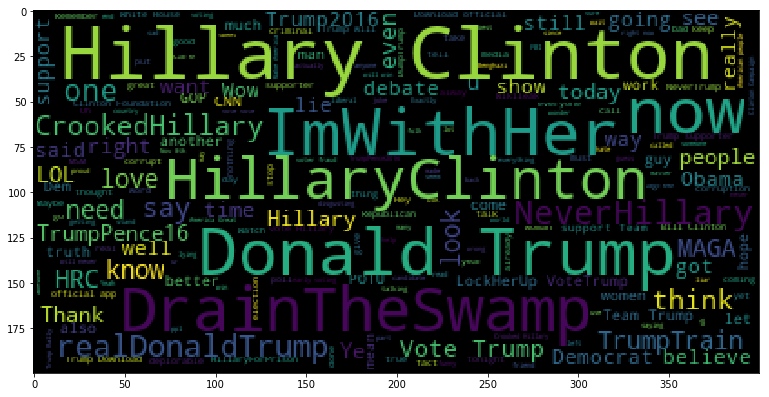

In [14]:
wordcloud = WordCloud().generate(' '.join(all_df.text) )
plt.figure(figsize=(13, 13))
plt.imshow(wordcloud)

In [10]:
def weighted_terms(vectorizer, tweets, num=100):
    '''display the top n most important words for this vectorizer with for the tweets
    vectorizer -- model to fit tweets, expecting instance of TfidfVectorizer
    tweets -- tweets going to transoform, expect pandas series format
    num -- how many top weighted words to show
    '''
    matrix = vectorizer.fit_transform(tweets)
    terms = vectorizer.get_feature_names()
    featres_weights = matrix.sum(axis=0)
    
    print('There are %d feature names.' % len(terms) )
    count = 0
    for index in np.argsort(-featres_weights).flat:
        count += 1
        if count > num:
            break

        print('%s %f' % (terms[index].ljust(25, ' '), featres_weights[0, index]) )

In [8]:
tfidf_vect = TfidfVectorizer(stop_words='english')

In [11]:
weighted_terms(tfidf_vect, all_df.text)

There are 139142 feature names.
trump                     27005.522195
imwithher                 22828.973483
vote                      20561.971338
hillary                   20113.388090
draintheswamp             19074.533118
neverhillary              14637.153699
realdonaldtrump           13158.617337
clinton                   12539.506840
hillaryclinton            10539.140319
just                      10288.026559
crookedhillary            9543.434491
maga                      8697.504474
america                   8403.450694
people                    8197.918167
don                       7916.137620
trumppence16              7856.320275
like                      7844.196876
trumptrain                7659.042418
time                      7237.959903
let                       6477.747580
president                 6289.293426
know                      6158.345944
voting                    6116.837997
make                      5881.545127
right                     5844.319630
election

We are planning to do clustering for this dataset, and interesting in how the above important key terms could help us to split. Here's some naive thoughts:

If we only cluster them into 2 groups, we should be get groups one mainly about trump's, and one mainly about clinton's.
If we cluster them into 3 groups, we migh get one group about trump, one for clinton and one neutral.
If we cluster them into 4 groups, we might get groups like pro and con trump, pro and con clinton.

Here are the words that might not be so helpful for the above purpose:

just, don (should be from don't, time, let, know, going, say, think, way, rt (re-tweet), said, new, does, day, got, says, doesn (from doesn't), ll (from I'll ?),  ve (from I've)

Note, I didn't include words like vote since they are expressing this person's will to vote or interested in election, and I am assuming there are neutral groups people who didn't interest in election at all but just tweet for fun and also words that have strong sentiment (like needs)

In [17]:
tweet_stop_words = text.ENGLISH_STOP_WORDS.union(['did', 'just', 'don', 'time', 'know', 'going', 'say', 'think', 'way', 'said', 'new', 'does', 'day', 'days', 'years', 'got', 'says', 'doesn', 'll', 've', 'twitter', 'pic', 'com', 'let', 'voting', 'rt', 'want', 'country', 'today', 'early', 'tonight', 'thing', 'didn', 'come', 'coming', 'tell', 'read'])

In [18]:
tfidf_vect = TfidfVectorizer(stop_words=tweet_stop_words)
weighted_terms(tfidf_vect, all_df.text)

There are 139105 feature names.
trump                     27640.629926
imwithher                 23068.302557
vote                      21406.724143
hillary                   20628.460665
draintheswamp             19218.047504
neverhillary              14764.379673
realdonaldtrump           13419.552805
clinton                   12768.711196
hillaryclinton            10786.935649
crookedhillary            9647.610391
maga                      8778.374988
america                   8662.832451
people                    8489.640567
like                      8120.753931
trumppence16              7936.602352
trumptrain                7752.797165
president                 6514.104428
make                      6087.831070
election                  6073.794206
right                     6066.160428
watch                     5920.034497
trump2016                 5856.807529
need                      5842.681079
donald                    5832.424959
love                      5758.456056
great    

In [62]:
def kmeans_weighted_terms(kmeans, matrix, feature_terms, num=25):
    '''display the top n most important words for this kmeans_model with for the given matrix and feature_terms
    Parameters:
    kmeans :  kmeans model to do clustering
    matrix : matrix you get after doing tfidf fit_transform
    feature_terms : list of featuer terms after you doing tfidf tif_transform
    num -- how many top weighted words to show
    '''

    predictions = kmeans.fit_predict(matrix)
    print('Inertia for this kmeans model :f' % kmeans.inertia_ )
    
    print('Centers (centroids):')
    for cluster, row in enumerate(kmeans.cluster_centers_):
        print('Center %d' % cluster)
        count = 0
        for index in np.argsort(-row):
            count += 1
            if count > num:
                break
            print('%s %f' % (terms[index].ljust(25, ' '), row[index]) )
        print()
    
    print("Aggregate clusters weights:")
    for cluster_num in range(kmeans.n_clusters):
        print('Clusters %d' % cluster_num )
        current_feature_weights = matrix[kmeans.labels_ == cluster_num].sum(axis=0)
        count = 0
        for index in np.argsort(-current_feature_weights).flat:
            count += 1
            if count > stop:
                break
            print('%s %f' % (terms[index].ljust(25, ' '), current_feature_weights[0, index]) )
        print()

In [61]:
kmeans = KMeans(n_clusters=2)
kmeans_weighted_terms(kmeans, matrix, terms)

Centers (centroids):
Center 0
imwithher                 0.400021
draintheswamp             0.329483
neverhillary              0.231893
vote                      0.005563
trump                     0.002329
hillary                   0.001793
yes                       0.001183
voted                     0.000982
hillaryclinton            0.000973
love                      0.000917
president                 0.000798
america                   0.000792
right                     0.000640
lol                       0.000637
knew                      0.000621
need                      0.000602
win                       0.000591
really                    0.000575
thank                     0.000569
proud                     0.000499
people                    0.000484
watch                     0.000483
100                       0.000469
like                      0.000454
good                      0.000449

Center 1
trump                     0.023430
vote                      0.017994
hillary        

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans_weighted_terms(kmeans, matrix, terms)

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans_weighted_terms(kmeans, matrix, terms)